In [26]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [27]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/DIG Historical Data 1_6.csv')

# Nhận thấy tập dữ liệu, ở cột Price giá tiền có dấu phẩy và đang ở dạng string
# Bỏ dấu phẩy
df['Price'] = df['Price'].str.replace(',', '')
# Chuyển sang dạng số
df['Price'] = pd.to_numeric(df['Price'])
df = df[::-1]

In [28]:
df1=df.reset_index()['Price']
df1.head()

0    11033.2
1    11457.6
2    12094.1
3    12094.1
4    12200.2
Name: Price, dtype: float64

In [29]:
df1

0       11033.2
1       11457.6
2       12094.1
3       12094.1
4       12200.2
         ...   
1593    27350.0
1594    27850.0
1595    27950.0
1596    27600.0
1597    27750.0
Name: Price, Length: 1598, dtype: float64

In [30]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [31]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [32]:
print(train_size)
print(test_size)

1278
319


In [33]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [34]:
# # 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
# time_step = 100
# X_train2, y_train2 = create_dataset(train_data, time_step)
# X_test2, y_test2 = create_dataset(test_data, time_step)

In [35]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100

x, y = create_dataset(df1, time_step)

X_train = x[:train_size-100]
X_test = x[train_size-100:]
y_train = y[:train_size-100]
y_test = y[train_size-100:]

In [36]:
# X_train = X_train2[:train_size-100]
# X_test = X_train2[train_size-100:]
# y_train = y_train2[:train_size-100]
# y_test = y_train2[train_size-100:]

In [37]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [38]:
X_test.shape

(319, 100, 1)

In [39]:
# 8. Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [40]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=24, batch_size=64, verbose=1)

Epoch 1/24
19/19 [==============================] - 1s 19ms/step - loss: 0.0098
Epoch 2/24
19/19 [==============================] - 0s 18ms/step - loss: 7.4958e-04
Epoch 3/24
19/19 [==============================] - 0s 20ms/step - loss: 5.4074e-04
Epoch 4/24
19/19 [==============================] - 0s 19ms/step - loss: 4.8543e-04
Epoch 5/24
19/19 [==============================] - 0s 18ms/step - loss: 4.8780e-04
Epoch 6/24
19/19 [==============================] - 0s 19ms/step - loss: 4.4651e-04
Epoch 7/24
19/19 [==============================] - 0s 19ms/step - loss: 4.4104e-04
Epoch 8/24
19/19 [==============================] - 0s 18ms/step - loss: 4.3281e-04
Epoch 9/24
19/19 [==============================] - 0s 19ms/step - loss: 4.1089e-04
Epoch 10/24
19/19 [==============================] - 0s 18ms/step - loss: 4.8133e-04
Epoch 11/24
19/19 [==============================] - 0s 20ms/step - loss: 3.9838e-04
Epoch 12/24
19/19 [==============================] - 0s 19ms/step - loss: 4.37

In [41]:
# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)


10/10 [==============================] - 0s 8ms/step


In [42]:
# 11. Chuẩn hóa dữ liệu y_pred, y_test
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [43]:
# Các độ đo
import numpy as np

# Mean Absolute Error
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Mean Squared Error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Root Mean Squared Error
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Mean Absolute Scaled Error
def mase(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    errors = np.abs(y_true - y_pred)
    return np.mean(errors / d)


In [44]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Tính độ đo cho tập kiểm tra
test_mae = mae(y_pred, y_test)
test_mape = mape(y_pred, y_test)
test_mase = mase(y_pred, y_test, y_train)
test_mse = mse(y_pred, y_test)
test_rmse = rmse(y_pred, y_test)

print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.4f}%')
print(f'Test MASE: {test_mase:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Test MAE: 881.8044
Test MAPE: 3.7248%
Test MASE: 120111.5771
Test MSE: 1271766.8477
Test RMSE: 1127.7264


In [45]:
# 13. Dự báo 30 ngày tiếp theo (test có 319 ngày)
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=259
i=0
while(i<30):

    if(len(temp_input)>250):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.15182812 0.15182812 0.15291977 0.15564888 0.15237395 0.15510306
 0.1561947  0.15674052 0.1611071  0.16984026 0.1660195  0.15946964
 0.1611071  0.16820279 0.15510306 0.1561947  0.14909901 0.15674052
 0.15182812 0.15237395 0.15510306 0.15946964 0.16656533 0.16492786
 0.17966506 0.17693595 0.18021088 0.17748177 0.17256937 0.15837799
 0.15783217 0.1561947  0.16274457 0.16001546 0.15564888 0.15510306
 0.16165292 0.15837799 0.15783217 0.16929444 0.17256937 0.18075671
 0.18294    0.17857342 0.18130253 0.19876884 0.20095213 0.207502
 0.20586453 0.21186858 0.207502   0.21186858 0.19986049 0.20422707
 0.207502   0.22169338 0.21896427 0.21405187 0.20968529 0.20913947
 0.2173268  0.22824325 0.2271516  0.2391597  0.23151818 0.21077693
 0.20531871 0.20531871 0.2025896  0.22169338 0.22278503 0.23042654
 0.23042654 0.2391597  0.24079716 0.2440721  0.24953032 0.24843868
 0.2489845  0.23151818 0.2440721  0.23806805 0.22605996 0.22496832
 0.22060174 0.2271516  0.23697641 0.22824325 0.20750

In [46]:
# 13b. Dự báo 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=259
i=0
while(i<60):

    if(len(temp_input)>250):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1


0 day input [0.15182812 0.15182812 0.15291977 0.15564888 0.15237395 0.15510306
 0.1561947  0.15674052 0.1611071  0.16984026 0.1660195  0.15946964
 0.1611071  0.16820279 0.15510306 0.1561947  0.14909901 0.15674052
 0.15182812 0.15237395 0.15510306 0.15946964 0.16656533 0.16492786
 0.17966506 0.17693595 0.18021088 0.17748177 0.17256937 0.15837799
 0.15783217 0.1561947  0.16274457 0.16001546 0.15564888 0.15510306
 0.16165292 0.15837799 0.15783217 0.16929444 0.17256937 0.18075671
 0.18294    0.17857342 0.18130253 0.19876884 0.20095213 0.207502
 0.20586453 0.21186858 0.207502   0.21186858 0.19986049 0.20422707
 0.207502   0.22169338 0.21896427 0.21405187 0.20968529 0.20913947
 0.2173268  0.22824325 0.2271516  0.2391597  0.23151818 0.21077693
 0.20531871 0.20531871 0.2025896  0.22169338 0.22278503 0.23042654
 0.23042654 0.2391597  0.24079716 0.2440721  0.24953032 0.24843868
 0.2489845  0.23151818 0.2440721  0.23806805 0.22605996 0.22496832
 0.22060174 0.2271516  0.23697641 0.22824325 0.20750

In [47]:
# 13c. Dự báo 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=259
i=0
while(i<90):

    if(len(temp_input)>250):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


0 day input [0.15182812 0.15182812 0.15291977 0.15564888 0.15237395 0.15510306
 0.1561947  0.15674052 0.1611071  0.16984026 0.1660195  0.15946964
 0.1611071  0.16820279 0.15510306 0.1561947  0.14909901 0.15674052
 0.15182812 0.15237395 0.15510306 0.15946964 0.16656533 0.16492786
 0.17966506 0.17693595 0.18021088 0.17748177 0.17256937 0.15837799
 0.15783217 0.1561947  0.16274457 0.16001546 0.15564888 0.15510306
 0.16165292 0.15837799 0.15783217 0.16929444 0.17256937 0.18075671
 0.18294    0.17857342 0.18130253 0.19876884 0.20095213 0.207502
 0.20586453 0.21186858 0.207502   0.21186858 0.19986049 0.20422707
 0.207502   0.22169338 0.21896427 0.21405187 0.20968529 0.20913947
 0.2173268  0.22824325 0.2271516  0.2391597  0.23151818 0.21077693
 0.20531871 0.20531871 0.2025896  0.22169338 0.22278503 0.23042654
 0.23042654 0.2391597  0.24079716 0.2440721  0.24953032 0.24843868
 0.2489845  0.23151818 0.2440721  0.23806805 0.22605996 0.22496832
 0.22060174 0.2271516  0.23697641 0.22824325 0.20750

In [48]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size+1-101, step=1)
test_data_index.shape

(219,)

In [49]:
y_pred.shape

(319, 1)

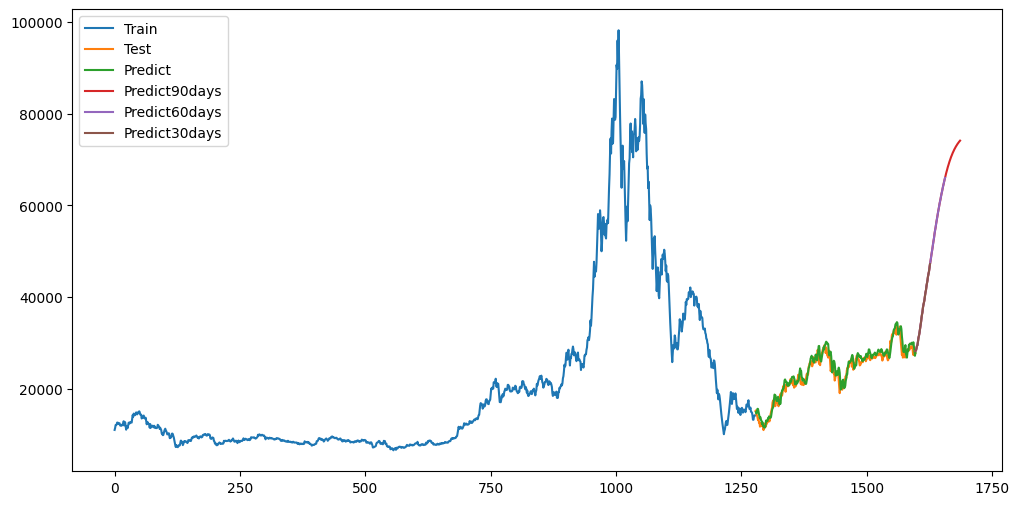

In [50]:
# 14.Vẽ hình
plt.figure(figsize=(12,6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size+1, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+1, stop=train_size+test_size+1, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index_90,scaler.inverse_transform(lst_output_90))

prediect_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index_60,scaler.inverse_transform(lst_output_60))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days','Predict30days'])
plt.show()